In [1]:
!pip install plotly
!pip install cufflinks
!pip install plotnine

In [2]:
import pandas as pd
from datetime import datetime
from plotnine import *
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px


%matplotlib inline

In [41]:
#CLEANING DATA
def processFunnelData(df):
   # the dataframe df must be structured so that
     # * each row represents a step of the funnel (numeric id in the stage column and description in the User_Status column)
     # * the columns are divided into:
     # - index columns that contain descriptive variables (eg. User_Status)
     # - columns that represent variables based on which to dissect the analysis of the funnel (e.g. year of subscription, bonus amount, ...)
    funnelData = df.copy()
    
    # definizione delle colonne indice che vengono escluse dall'analisi
    indexCols = ["Registration_Step","Registration_SubStep","Description_Registration_Step","User_Status_Detail"]
    varCols = [x for x in df.columns.tolist() if x not in indexCols]
    
    # per ogni variabile su cui valutare la progressine nel funnel vengono calcolate diverse statistiche
    # (si ricordi che ogni riga rappresenta uno stato del funnel) 
    for col in varCols:
        funnelData.sort_values(by="stage", ascending=False, inplace=True)
        
        # *col*_funnelProgression contiene l'avanzamento progressivo nel funnel. Per ogni riga, questa
        # statistica indica quante leads hanno completato il relativo step del processo di registrazione
        # o uno step successivo.
        funnelData["{}_funnelProgression".format(col)] = funnelData[col].cumsum()
        funnelData.sort_values(by="stage", ascending=True, inplace=True)
        
        # *col*_startingFrom è una variabile di supporto che indica quante leads hanno completato
        # lo step precedente
        funnelData["{}_startingFrom".format(col)] = funnelData["{}_funnelProgression".format(col)].shift()
        
        # *col*_stageLoss indica quante leads sono arrivate allo stage relativo alla riga,
        # ma non lo hanno completato
        funnelData["{}_stageLoss".format(col)] = funnelData["{}_funnelProgression".format(col)].diff()
        
        # *col*_keptStage indica la completion rate del singolo stage del funnel. Il valore in questa
        # colonna è la percentuale di leads che hanno completato lo step fatte 100 le lead che sono 
        # arrivate allo step. Es: un valore di 0.50 indica che su 100 leads arrivate allo step X, solo 50
        # lo hanno completato.
        funnelData["{}_keptStage".format(col)] = funnelData["{}_funnelProgression".format(col)]/funnelData["{}_startingFrom".format(col)]
        
        # *col*_keptOverll traccia in temini percentuali la progressione nel funnel. Il valore in questa
        # colonna è la percentuale di leads che hanno completato lo step fatte 100 le lead che hanno 
        # iniziato il processo di sottoscrizione. Es: un valore di 0.50 indica che su 100 leads che hanno
        # iniziato il processo di sottoscrizione, solo 50 sono arrivte a completare lo step X.
        funnelData["{}_keptOverall".format(col)]  = funnelData["{}_funnelProgression".format(col)]/funnelData["{}_funnelProgression".format(col)].max()
        
    return funnelData

In [4]:
a2users = pd.read_csv('a2usersOK.csv',sep=';',low_memory=False)
pd.set_option('max_columns', None) #to show all columns #or: a2users.columns

exclude = a2users["Last_Online_Subscription"] == "AcomeA"
#a2users = a2users[~exclude].copy()

a2users["DateTime_Subscription"] = pd.to_datetime(a2users["DateTime_Subscription"])
subset = a2users["DateTime_Subscription"].apply(lambda x: x>datetime(2017,10,1))
a2users = a2users[subset].copy()
del subset

#Encoding column "stage"

#The subscription year (subscr_year): replace 0 for NA value and converted to int.
a2users.loc[pd.isna(a2users["subscr_year"]),"subscr_year"] = 0
a2users["subscr_year"] = a2users["subscr_year"].astype(int)
# move into make_dataset.py or into the data extraction queries
a2users = a2users[a2users["User_Status_Detail"]!="A - Solo su AcomeA-Online"].copy()

a2users["stage"] = -1

a2users.loc[a2users["User_Status_Detail"]=="0 - E-Mail non verificata","stage"] = 0
a2users.loc[a2users["User_Status_Detail"]=="1 - Mail Validata","stage"] = 1
a2users.loc[a2users["User_Status_Detail"]=="2 - Sottoscrizione Iniziata","stage"] = 2
a2users.loc[a2users["User_Status_Detail"]=="3 - Codice Fiscale OK","stage"] = 3
a2users.loc[a2users["User_Status_Detail"]=="4 - Dati Personali OK","stage"] = 4
a2users.loc[a2users["User_Status_Detail"]=="5 - Residenza OK","stage"] = 5
a2users.loc[a2users["User_Status_Detail"]=="6 - Documento ID OK","stage"] = 6
a2users.loc[a2users["User_Status_Detail"]=="7 - Documenti Firmati","stage"] = 7
a2users.loc[a2users["User_Status_Detail"]=="8 - Antiriciclaggio OK","stage"] = 8
a2users.loc[a2users["User_Status_Detail"]=="9 - Fondo Scelto","stage"] = 9
a2users.loc[a2users["User_Status_Detail"]=="10 - Concluso","stage"] = 10

a2users = a2users[a2users["stage"]>-1].copy()

## Encoding info_loginType

a2users["inf_loginType"] = "Altri"

fb = (a2users["has_ID_Facebook"]==1) & (a2users["has_ID_GPlus"]==0)
a2users.loc[fb,"inf_loginType"] = "Facebook"

gp = (a2users["has_ID_Facebook"]==0) & (a2users["has_ID_GPlus"]==1)
a2users.loc[gp,"inf_loginType"] = "Google"

multi = (a2users["has_ID_Facebook"]==1) & (a2users["has_ID_GPlus"]==1)
a2users.loc[multi,"inf_loginType"] = "Multi"


# <font color='navy'> ASSIGMENT FINTECH LAB - GIMMI5 PROJECT </font> 
</br> </br>
    
**Name**: Nguyen Quynh Anh   
 </br> **Matricole**: `947097` </br>
 
</br> 


</br> **Program**: Data Science and Economics </br>

</BR> **Instructor**: Giuseppe Codazzi </br> </font>

   <font color='navy'> My assignment is focusing on exploring subscription stage data and summarize their main characteristics by Contingency tables and Visualized plots. Thereby, it is possible to see what the data can tell us beyond the formal modeling or hypothesis testing task. I added some comments at the end of each part. </font>

##  <font color='blue'>Stage vs Age </font> 

In [48]:
qaa = pd.read_csv('API_Subcription_DATA.csv',sep=';',low_memory=False)
qaa.head(3)

,"ID,COMPLETED_STEP,DATE_EVENT,NETWORK_ID,USER_ID,SESSO,ETA,TEMP_PROMOTION_CODE_ID,LAST_TIME"
0,"1710,/api/subscribe-antiriciclaggio.json,2019-..."
1,"1711,/api/subscribe-contract-subscription.json..."
2,"1712,/api/subscribe-codice-fiscale.json,2019-1..."


In [46]:
a2users.head(10)

,ID_User,ID_Promotion,ID_Promo_Code,Age,Sex,Email_Domain,Flag_User_Disabled,Date_Last_Access,Registration_Case,Description_Registration_Case,Registration_Step,Registration_SubStep,Description_Registration_Step,User_Status,has_ID_Facebook,has_ID_GPlus,User_Class,Flag_Test_User,Residence_Province,Favourite_Contract_Class,Activation_Payment_Method,Payment_Method,Subscription_Bonus,DateTime_First_Login,First_Login_Type,First_Login_Asset,DateTime_Last_Login,Last_Login_Type,Last_Login_Asset,DateTime_Subscription,DateTime_First_Conclusion,DateTime_Last_Conclusion,DateTime_First_Investment,Last_Online_Subscription,All_Online_Subscriptions,User_Status_Detail,subscr_year,subscr_month,infYear,infGender,ageAtSubscription,ageBand,stage,inf_loginType,Countnumber,Countnumbera
0,1,32,40100.0,44.0,1,GMAIL,0.0,06/09/2019,1.0,Nuovo Utente,W,4.0,10 - Concluso,REAL,1,1,A2,0.0,MI,A2,RD,RD,10.0,12/03/2019,GPLUS,Browser,06/09/2019,GPLUS,App-Android,2019-12-03 21:24:00,22/08/2019 10:01,22/08/2019 10:01,NaN,Gimme5,Gimme5,10 - Concluso,2019,3,1975.0,1,43,40-45,10,Multi,1,1
2,3,35,40103.0,28.0,1,GMAIL,0.0,05/09/2019,1.0,Nuovo Utente,W,4.0,10 - Concluso,REAL,0,0,A2,0.0,TO,A2,RD,RD,5.0,30/03/2019,MANUAL,App-Android,05/09/2019,MANUAL,App-Android,2019-03-30 00:41:00,01/04/2019 10:02,01/04/2019 10:02,NaN,Gimme5,Gimme5,10 - Concluso,2019,3,1990.0,1,28,25-30,10,Altri,1,1
3,4,0,NaN,32.0,1,LIBERO,0.0,05/09/2019,1.0,Nuovo Utente,W,4.0,10 - Concluso,REAL,0,0,A2,0.0,VE,A2,RD,RD,NaN,20/11/2018,MANUAL,Browser,05/09/2019,MANUAL,App-Android,2018-11-19 14:31:00,20/12/2018 10:02,20/12/2018 10:02,19/02/2019 00:00,Gimme5,Gimme5,10 - Concluso,2018,11,1987.0,1,31,30-35,10,Altri,1,1
5,6,0,NaN,37.0,1,GMAIL,0.0,05/09/2019,1.0,Nuovo Utente,Y,4.0,9 - Fondo Scelto,REAL,0,0,A2,0.0,SA,A2,NaN,RD,NaN,14/02/2018,MANUAL,Browser,05/09/2019,MANUAL,App-Android,2018-02-14 12:06:00,16/02/2018 10:01,16/02/2018 10:01,21/02/2018 00:00,Gimme5,Gimme5,10 - Concluso,2018,2,1982.0,1,35,35-40,10,Altri,1,1
6,7,0,NaN,62.0,1,GMAIL,0.0,06/09/2019,1.0,Nuovo Utente,Y,4.0,9 - Fondo Scelto,REAL,0,0,A2,0.0,MI,A2,NaN,RD,NaN,13/05/2018,MANUAL,App-Android,06/09/2019,MANUAL,App-Android,2018-05-13 17:00:00,14/05/2018 10:02,14/05/2018 10:02,17/05/2018 00:00,Gimme5,Gimme5,10 - Concluso,2018,5,1957.0,1,60,60-65,10,Altri,1,1
7,8,0,NaN,58.0,1,GMAIL,0.0,05/09/2019,1.0,Nuovo Utente,W,4.0,10 - Concluso,REAL,0,0,A2,0.0,CT,A2,BO,BO,NaN,10/08/2018,MANUAL,Browser,05/09/2019,MANUAL,App-iOS,2018-10-08 15:57:00,13/08/2018 10:03,13/08/2018 10:03,18/08/2018 00:00,Gimme5,Gimme5,10 - Concluso,2018,8,1961.0,1,57,55-60,10,Altri,1,1
8,9,0,NaN,30.0,1,GMAIL,0.0,05/09/2019,1.0,Nuovo Utente,W,4.0,10 - Concluso,REAL,0,1,A2,0.0,PZ,A2,BO,BO,NaN,04/01/2018,GPLUS,Browser,05/09/2019,NaN,NaN,2018-04-01 12:39:00,05/01/2018 10:01,02/09/2019 10:01,05/09/2019 00:00,Gimme5,Gimme5,10 - Concluso,2018,1,1989.0,1,28,25-30,10,Google,1,1
9,10,27,40087.0,43.0,1,HOTMAIL,0.0,05/09/2019,1.0,Nuovo Utente,W,4.0,10 - Concluso,REAL,1,0,A2,0.0,MI,A2,RD,RD,10.0,21/03/2019,FACEBOOK,Browser,05/09/2019,MANUAL,Browser,2019-03-21 21:49:00,22/03/2019 10:02,22/03/2019 10:02,NaN,Gimme5,Gimme5,10 - Concluso,2019,3,1976.0,1,43,40-45,10,Facebook,1,1
10,11,24,40084.0,29.0,2,GMAIL,0.0,05/09/2019,1.0,Nuovo Utente,W,4.0,10 - Concluso,REAL,0,0,A2,0.0,RM,A2,BO,BO,5.0,15/02/2019,MANUAL,Browser,05/09/2019,MANUAL,App-Android,2019-02-15 17:35:00,18/02/2019 10:05,18/02/2019 10:05,21/02/2019 00:00,Gimme5,Gimme5,10 - Concluso,2019,2,1990.0,2,29,25-30,10,Altri,1,1
11,12,0,NaN,32.0,1,GMAIL,0.0,06/09/2019,1.0,Nuovo Utente,W,4.0,10 - Concluso,REAL,0,0,A2,0.0,BO,A2,RD,RD,NaN,09/08/2018,MANUAL,App-Android,06/09/2019,NaN,NaN,2018-09-08 14:59:00,10/08/2018 10:01,21/08/2018 10:02,NaN,Gimme5,Gimme5,10 - Concluso,2018,8,1987.0,1,31,30-35,10,Altri,1,1


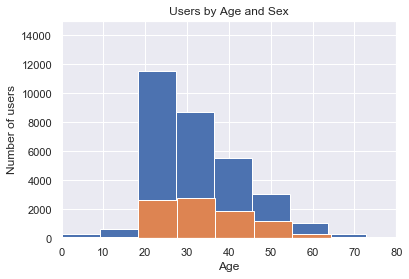

In [5]:
#1 Histogram The number of users by Age and Sex
sns.set()
ax = a2users.groupby('Sex').Age.hist()
plt.ylim(0, 15000)
plt.xlim(0, 80)
plt.xlabel("Age")
plt.ylabel("Number of users")
plt.title('Users by Age and Sex')
plt.show()


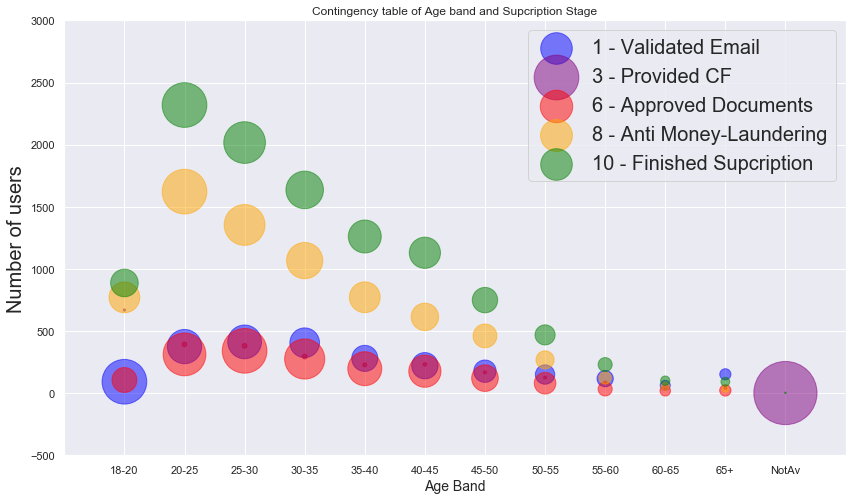

In [37]:
#2 Age Band vs Stage: Plot shows the number of users in different ageband at five stages of the funnel 

a2users['Countnumber'] = 1
stage2 = a2users.pivot_table('Countnumber', index = 'ageBand', columns = 'Description_Registration_Step', aggfunc= 'sum')
ageband = a2users['ageBand'].unique()
ageband.sort()

#normalize idexes
i_normal = stage2["1 - Mail Validata"] / stage2["1 - Mail Validata"].max()
b_normal = stage2["3 - Codice Fiscale OK"] / stage2['3 - Codice Fiscale OK'].max()
c_normal = stage2["10 - Concluso"] / (stage2["10 - Concluso"].max())
d_normal = stage2["6 - Documento ID OK"] / (stage2["6 - Documento ID OK"].max())
e_normal = stage2["8 - Antiriciclaggio OK"] / (stage2["8 - Antiriciclaggio OK"].max())

#plot
plt.figure(figsize=(14, 8))
ax1 = plt.scatter(ageband, stage2["1 - Mail Validata"], 
                  color='blue', label = '1 - Validated Email',
                 alpha=0.5,
                 s = b_normal * 2000)
ax2 = plt.scatter(ageband, stage2["3 - Codice Fiscale OK"], 
                  color='purple', label = "3 - Provided CF",
                 alpha=0.5,
                 s = i_normal * 4000 )
ax3 = plt.scatter(ageband, stage2["6 - Documento ID OK"], 
                  color='red', label =  '6 - Approved Documents',
                 alpha=0.5,
                 s = d_normal * 2000)
ax4 = plt.scatter(ageband, stage2["8 - Antiriciclaggio OK"], 
                  color='orange', label =  '8 - Anti Money-Laundering',
                 alpha=0.5,
                 s = e_normal * 2000)
ax5 = plt.scatter(ageband, stage2["10 - Concluso"], 
                  color='green', label = '10 - Finished Supcription',
                 alpha=0.5,
                 s = c_normal * 2000)
plt.xlabel("Age Band", size=14)
plt.ylabel("Number of users", size=20)
plt.ylim(-500, 3000)
plt.xlim(-1, 12)
plt.title("Contingency table of Age band and Supcription Stage")
plt.legend(handles=[ax1, ax2, ax3,ax4, ax5], loc =1, prop={'size': 20})
plt.show()

### <mark> Comments: </mark> 
1. The majority of users are **from 20 to 50 years old**.
      * 20-30 years-old are the age band with the highest number of users.
      * The number of users are under 20 and over 60 are tiny.
2. There are similarity between the number of usersin the stage 1 and 3.
     * The number of users who are currently stopping in stage **1 - Validated Email** and **3 - Provided CF** are pretty the same for most of ageBand from 20 to 65.
     * The number of under 20 years old users who stopped in the **Validated Email** stage are much lower than who stopped in the **Provided Codice Fiscale** stage.
3. The last two stages: **Anti Money-Laundering** and **Finished Supcription** have the same distribution in term of the number of user who at each ageBand.


## <font color='blue'> Stage vs Channel   </font> 

In [13]:
#3 Contingency table of Stage and Cannal
a2users['Countnumber'] = 1
stage = a2users.pivot_table('Countnumber', index = ['inf_loginType',"ageBand"], columns = ["stage","User_Status_Detail"], aggfunc= 'sum')
#stage.fillna(0)
cm = sns.light_palette("red", as_cmap=True)
stage.style.background_gradient(cmap=cm)

/Users/Jyanqa/opt/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less


(-1, 5)

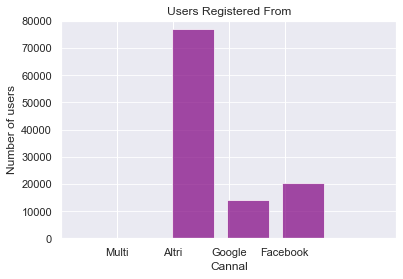

In [38]:
#Plot Histogram 

logintype=a2users["inf_loginType"]

n, bins, patches = plt.hist(x=logintype, bins='auto', color='purple',
                            alpha=0.7, width=0.75)
plt.grid(axis='y', alpha=0.85)
plt.xlabel('Cannal')
plt.ylabel('Number of users')
plt.title('Users Registered From')
plt.text(9, 100, r'')
maxfreq = n.max()
plt.ylim(0, 80000)
plt.xlim(-1, 5)

### <mark> Comments:</mark> 
1. More than 70% of users logged in via **Altri** Channel and 1/3 users left used Google and Facebook to register themselves to the system. 
2. Regardless of channel users used to login, we do not have age information of any user who has dropped **before 3-Codice Fiscale OK** stage. 
3. The majority of user who dropped in the last step of the funnel **9- Scelto-Fondo** are users from two ageband 18-20 and 20-25 group. Also, the group 18-20 yearsold accounted for the biggest part of users who dropped in **3- Codice Fiscale OK** stage.


## <font color='blue'> Stage vs Sex   </font> 

In [40]:
#5 Contingency table of Stage and Sex
a2users['Countnumber'] = 1
stage1 = a2users.pivot_table('Countnumber', index = ['stage', 'User_Status_Detail'], columns = 'Sex' , aggfunc= 'sum')
stage1
cm = sns.light_palette("green", as_cmap=True)
stage1.style.background_gradient(cmap=cm)



/Users/Jyanqa/opt/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less


,Sex,1,2,3
stage,User_Status_Detail,,,
0,0 - E-Mail non verificata,1.000000,nan,8732.000000
1,1 - Mail Validata,201.000000,73.000000,17280.000000
2,2 - Sottoscrizione Iniziata,1351.000000,302.000000,43189.000000
3,3 - Codice Fiscale OK,161.000000,28.000000,2469.000000
4,4 - Dati Personali OK,2007.000000,847.000000,nan
5,5 - Residenza OK,6380.000000,2653.000000,3.000000
6,6 - Documento ID OK,1208.000000,474.000000,2.000000
7,7 - Documenti Firmati,292.000000,107.000000,1.000000
8,8 - Antiriciclaggio OK,5671.000000,1462.000000,7.000000


### <mark> Comments: </mark> 
1. The highest number of users, almost 13,000 users, who finished the registrantion process have the gender in category `1`. 
2. There are a huge number of users in gender category `1` and `2` is stopping in the three stages: **5- Residenza OK**, **8-Anticiclaggio OK** and the last step **10-Concluso**.

## <font color='blue'> Overview Stage over Years  </font> 

In [45]:
#6 Stage vs year
funnelDataY = a2users.groupby(["stage","User_Status_Detail","subscr_year"])["ID_User"].count().reset_index()
funnelStageYear = pd.pivot_table(funnelDataY, index=["User_Status_Detail"],columns="subscr_year",values="ID_User")
cm = sns.light_palette("orange", as_cmap=True)
funnelStageYear.style.background_gradient(cmap=cm)


subscr_year,2017,2018,2019
User_Status_Detail,,,
0 - E-Mail non verificata,1258,4210,3265
1 - Mail Validata,2418,8228,6908
10 - Concluso,1484,8348,5804
2 - Sottoscrizione Iniziata,4220,25045,15577
3 - Codice Fiscale OK,258,1244,1156
4 - Dati Personali OK,205,1459,1190
5 - Residenza OK,565,4299,4172
6 - Documento ID OK,199,981,504
7 - Documenti Firmati,89,196,115


#### <mark> Comments: </mark>
1. Stage **2- Sottoscrizione Iniziata** is the stage from which users dropped the most in over three years: 2017, 2018 and 2019.
2. The number of users who dropped in the stage `2` in 2020 **decreases approximately 40%** respect to the previous year 2019. In fact, there were *25,045* users who dropped in Sottoscrizione Iniziata stage in 2018, then it was *15,577* in 2019.
3. Three stages in which users significantly dropped still are **2- Sottoscrizione Iniziata**, **5- Residenza OK**, and **8- Anticiclaggio OK** over years.